In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import os

# Chargement de la base Sentiment140 préprocessée 

In [2]:
STOP_WORDS = True
LEMMATIZATION = True
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2"))

In [3]:
df = df.sample(50000, random_state=1234)
df.sentiment = df.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')
df

,sentiment,id,date,query_string,user,text
1062048,Positive,1964017646,Fri May 29 13:35:57 PDT 2009,NO_QUERY,ashakur,@PcShakur I guess so. We should go make it a f...
1236895,Positive,1992914899,Mon Jun 01 09:31:47 PDT 2009,NO_QUERY,RabbiShaiSpecht,@PsychicSophie Thank you!
1237054,Positive,1992954642,Mon Jun 01 09:35:38 PDT 2009,NO_QUERY,RobinRene7,it's just another day here at the office...I a...
229979,Negative,1978627799,Sat May 30 23:57:09 PDT 2009,NO_QUERY,valfvergara,@triciasays i miss kickboxing
760772,Negative,2296927988,Tue Jun 23 09:48:35 PDT 2009,NO_QUERY,SarahAnnGreen,@AmandaFClark Thats rubbish!
...,...,...,...,...,...,...
46422,Negative,1677402582,Sat May 02 01:53:46 PDT 2009,NO_QUERY,kmac1984,wondering what the hell is gonna happen next??...
34170,Negative,1564728728,Mon Apr 20 04:42:44 PDT 2009,NO_QUERY,engers,@jkoxvold Me too
888464,Positive,1687307615,Sun May 03 08:20:39 PDT 2009,NO_QUERY,_Alectrona_,I'm off Will maybe tweet later...Bye!
292279,Negative,1995953530,Mon Jun 01 14:18:18 PDT 2009,NO_QUERY,TraceyyMartinn,stomach hurts and i desperatly want to go sho...


In [4]:
X = df.text.to_list()
Y = df.sentiment.to_list()

data_train, data_test, y_train, y_test  = train_test_split(
        X, 
        Y,
        train_size=0.80,
        random_state=1234)

# Count Vectorizer
## Exemple

In [5]:
arr = ["Car was cleaned by Jack", "Jack was cleaned by Car", "Hello"]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['by', 'car', 'cleaned', 'hello', 'jack', 'was']

In [6]:
print(X.toarray())

[[1 1 1 0 1 1]
 [1 1 1 0 1 1]
 [0 0 0 1 0 0]]


## Application

On fit à présent le vectorizer sur l'ensemble des données (train + test) pour avoir des vecteurs de mêmes dimensions (mêmes nombres de features).

In [7]:
vectorizer = CountVectorizer()

vectorizer.fit(data_train+data_test)
X_train = vectorizer.transform(data_train).toarray()
X_test = vectorizer.transform(data_test).toarray()

print(f"Nombre de features : {len(vectorizer.get_feature_names())}")

Nombre de features : 58930


In [8]:
vectorizer = CountVectorizer(max_features = 1000)

vectorizer.fit(data_train+data_test)
X_train = vectorizer.transform(data_train).toarray()
X_test = vectorizer.transform(data_test).toarray()

print(f"Nombre de features : {len(vectorizer.get_feature_names())}")

Nombre de features : 1000


In [9]:
log_model= LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [10]:
confusion_matrix(y_test, y_pred)

array([[3580, 1366],
       [1093, 3961]], dtype=int64)

In [11]:
def conf_matrix(data_train, data_test, y_train, y_test, vectorizer, model):
    vectorizer.fit(data_train+data_test)
    X_train = vectorizer.transform(data_train).toarray()
    X_test = vectorizer.transform(data_test).toarray()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)    
    sc_balanced_accuracy = sklearn.metrics.balanced_accuracy_score(y_pred, y_test)
    sc_f1 = sklearn.metrics.f1_score(y_pred, y_test, pos_label="Positive")
    sc_recall = sklearn.metrics.recall_score(y_pred, y_test, pos_label="Positive")
    sc_precision = sklearn.metrics.precision_score(y_pred, y_test, pos_label="Positive")
    
    sklearn.metrics.plot_confusion_matrix(model, X_test, y_test)
    plt.show()

    print(f"Accuracy : {sc_accuracy}")
    print(f"Balanced accuracy : {sc_balanced_accuracy}")
    print(f"Recall : {sc_recall}")
    print(f"Precision : {sc_precision}")
    print(f"F1 : {sc_f1}")
    

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


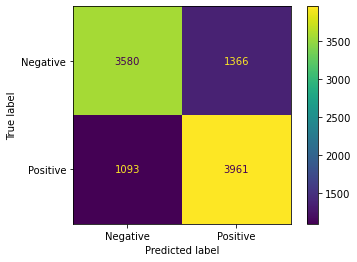

Accuracy : 0.7541
Balanced accuracy : 0.7548368178438088
Recall : 0.7435704899568237
Precision : 0.7837356549267906
F1 : 0.7631249397938542


In [12]:
conf_matrix(data_train, data_test, y_train, y_test, CountVectorizer(max_features = 1000), LogisticRegression())

# TF-IDF
## Exemple

In [13]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue', 'by', 'car', 'cleaned', 'hello', 'jack', 'red', 'was']

In [14]:
print(X.toarray())

[[0.50689001 0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.         0.38550292]
 [0.         0.38550292 0.38550292 0.38550292 0.         0.38550292
  0.50689001 0.38550292]
 [0.         0.         0.         0.         1.         0.
  0.         0.        ]]


In [15]:
## Application

In [16]:
vectorizer = TfidfVectorizer()

vectorizer.fit(data_train+data_test)
X_train = vectorizer.transform(data_train).toarray()
X_test = vectorizer.transform(data_test).toarray()
print(f"Nombre de features : {len(vectorizer.get_feature_names())}")

Nombre de features : 58930


In [17]:
vectorizer = TfidfVectorizer(max_features = 1000)

vectorizer.fit(data_train+data_test)
X_train = vectorizer.transform(data_train).toarray()
X_test = vectorizer.transform(data_test).toarray()
print(f"Nombre de features : {len(vectorizer.get_feature_names())}")

Nombre de features : 1000


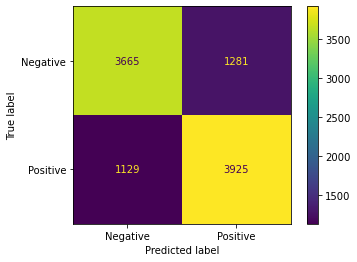

Accuracy : 0.759
Balanced accuracy : 0.759217526197669
Recall : 0.753937764118325
Precision : 0.7766125840918084
F1 : 0.7651072124756335


In [18]:
conf_matrix(data_train, data_test, y_train, y_test, TfidfVectorizer(max_features = 1000), LogisticRegression())

# N-grams
## Exemple

In [19]:
arr = ["Blue car was cleaned by Jack", "Jack was cleaned by red car", "Hello"]
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(arr)
vectorizer.get_feature_names()

['blue car',
 'by jack',
 'by red',
 'car was',
 'cleaned by',
 'jack was',
 'red car',
 'was cleaned']

In [20]:
print(X.toarray())

[[1 1 0 1 1 0 0 1]
 [0 0 1 0 1 1 1 1]
 [0 0 0 0 0 0 0 0]]


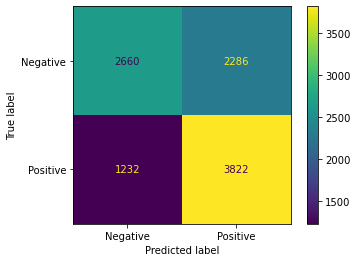

Accuracy : 0.6482
Balanced accuracy : 0.6545949880567059
Recall : 0.6257367387033399
Precision : 0.7562326869806094
F1 : 0.6848235083318402


In [21]:
conf_matrix(data_train, data_test, y_train, y_test, CountVectorizer(max_features = 1000, ngram_range=(2,2)), LogisticRegression())